In [195]:
import pandas as pd
import numpy as np 
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import xgboost as xgb



In [196]:
Data_to_add = pd.read_csv('../Datasets originales/Df_sold_homes_to_add.csv')

In [197]:
propertys_ids_to_add = Data_to_add['property_id'].to_list()

In [198]:
Houses_for_sale = pd.read_csv('../Dataset limpios/Houses_for_sale_processed.csv')

In [199]:
Data = pd.read_csv('../Dataset limpios/Houses_sold_processed.csv')

In [200]:
dicts = []
for id in propertys_ids_to_add:
    
    if id not in Data['property_id'].to_list():
        dict = Houses_for_sale[Houses_for_sale['property_id']==id].to_dict()
        dicts.append(dict)

In [201]:
print(f'''Hay un total de {len(propertys_ids_to_add)} ids para añadir al dataset de entrenamiento de los cuales \n
      {len(dicts)} no estaban ya en el dataset''')

Hay un total de 6662 ids para añadir al dataset de entrenamiento de los cuales 

      6650 no estaban ya en el dataset


In [202]:
dfs = []
for dict in dicts: 
    df = pd.DataFrame(dict)
    dfs.append(df)
Data_to_add = pd.concat(dfs,ignore_index=True)

In [203]:
Data_to_add.head(2)

,property_id,lon,lat,postal_code,state,city,state_code,line,fips_code,name,...,beds,type,primary_photo,tags,list_date,photos,list_price,listing_id,primary,status
0,1.000163e+09,-122.340542,37.94899,94804.0,California,Richmond,CA,2814 Lowell Ave,6013.0,Contra Costa,...,2.0,single_family,https://ap.rdcpix.com/c40746b359c3d70b1696f82f...,"['central_air', 'community_outdoor_space', 'di...",2023-09-16,https://ap.rdcpix.com/c40746b359c3d70b1696f82f...,899000.0,2.959741e+09,1.0,for_sale
1,1.000749e+09,-122.196956,47.91802,98208.0,Washington,Everett,WA,8729 Del Campo Dr,53061.0,Snohomish,...,4.0,single_family,https://ap.rdcpix.com/7501bd1b85a32ead25dd46b5...,"['basement', 'community_outdoor_space', 'dinin...",2023-09-27,https://ap.rdcpix.com/7501bd1b85a32ead25dd46b5...,870000.0,2.960037e+09,1.0,for_sale


In [204]:
Data_complete = pd.concat([Data,Data_to_add], ignore_index=True)

In [205]:
columns = ['state_code', 'line','postal_code', 'state','name']
Data_complete.drop(columns = columns, inplace=True)

In [206]:
columns = ['street_view_url', 'primary_photo','photos', 'listing_id']
Data_complete.drop(columns = columns, inplace=True)

In [207]:
def year():#return current year
    
    current_time = time.time()

    time_structure = time.localtime(current_time)

    
    current_year = time_structure.tm_year

    return current_year

In [208]:
def get_age(year_text):

    current_year = year()

    return current_year - year_text 

In [209]:
Data_complete['year_built'] = Data_complete['year_built'].apply(get_age)

In [210]:
Data_complete.drop(columns='status',inplace = True)

In [211]:
Data_complete.drop('primary', axis=1,inplace = True)

In [212]:
label_encoder = LabelEncoder()


In [213]:
Data_complete['encoded_city'] = label_encoder.fit_transform(Data_complete['city'])
Data_complete.drop(columns='city', inplace = True)

In [214]:
Data_complete['encoded_type'] = label_encoder.fit_transform(Data_complete['type'])
Data_complete.drop(columns='type', inplace = True)

In [215]:
top_50_tags = pd.read_csv('most_commun_tags.csv')

In [216]:
my_ref_list = top_50_tags['tag'].to_list()

    # Iterate through each column
for column in Data_complete[['tags']]:
    # Initialize a dictionary to store One-Hot Encoding results
    encoding_dict = {}
    
    # Iterate through each value in the column's list
    for value in my_ref_list:
        # Check if the value is in the list
        encoding_dict[f'{value}'] = [int(isinstance(lst, list) and value in lst) for lst in Data_complete[column]]
    
    # Create a new DataFrame from the encoding_dict
    encoding_df = pd.DataFrame(encoding_dict)


Data_complete = Data_complete.reset_index().drop(columns='index')
# Concatenate the dataframes side by side
result = pd.concat([Data_complete, encoding_df], axis=1)

In [217]:
result.drop(columns='tags', inplace=True)

In [218]:
result.set_index('property_id',inplace=True)

In [219]:
def convert_bools(value):
    try:
        value = int(value)
    except:
        value=value
    return value

In [220]:
result['is_new_construction'] = result['is_new_construction'].apply(convert_bools)

In [221]:
for column in result.columns:
    if 'is_' in column:
        result[column] = result[column].apply(convert_bools)

In [222]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17741 entries, 1000385902.0 to 9993679106.0
Data columns (total 71 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   lon                          17585 non-null  float64
 1   lat                          17585 non-null  float64
 2   fips_code                    16989 non-null  float64
 3   is_new_construction          117 non-null    float64
 4   is_for_rent                  0 non-null      float64
 5   is_contingent                215 non-null    float64
 6   is_price_reduced             2240 non-null   float64
 7   is_foreclosure               49 non-null     float64
 8   is_plan                      0 non-null      float64
 9   is_coming_soon               206 non-null    float64
 10  year_built                   16851 non-null  float64
 11  lot_sqft                     15545 non-null  float64
 12  sqft                         16465 non-null  float64
 13  bat

In [223]:
result.drop(columns='list_date', inplace=True)

In [224]:
result.dropna(subset='list_price', inplace=True)

In [225]:
price =result.reset_index().set_index('encoded_type')

In [226]:
price = price.sort_values(by='encoded_type').reset_index()
price = price[['property_id','list_price']]

In [227]:
price

,property_id,list_price
0,8.600374e+09,995000.0
1,1.829110e+09,370000.0
2,7.271313e+09,170000.0
3,7.691586e+09,173000.0
4,1.171667e+09,560000.0
...,...,...
15897,2.494361e+09,340000.0
15898,2.493865e+09,690000.0
15899,2.581111e+09,630000.0
15900,2.133101e+09,535000.0


In [228]:
# Define a window size
window_size = 300

# Set the sigma value, which is 3, although a slightly larger value could be chosen due to data dispersion
sigma = 10

# Define the  ceiling of the graph
price['ceiling'] = price['list_price'].rolling(window=window_size).mean() + (sigma * price['list_price'].rolling(window=window_size).std())

price['floor'] =( price['list_price'].rolling(window=window_size).mean() - (0.25*sigma * price['list_price'].rolling(window=window_size).mean().std()))


<Axes: >

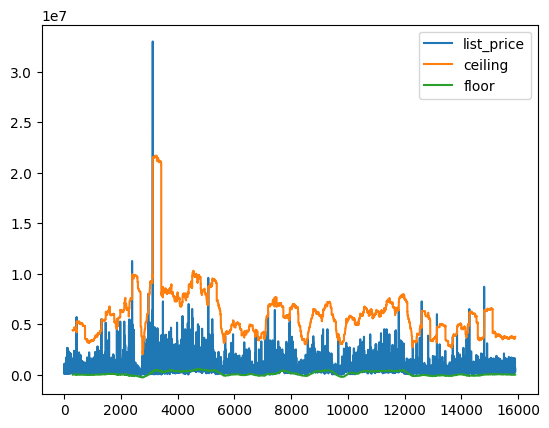

In [238]:
price[['list_price','ceiling','floor']].plot()

<Axes: >

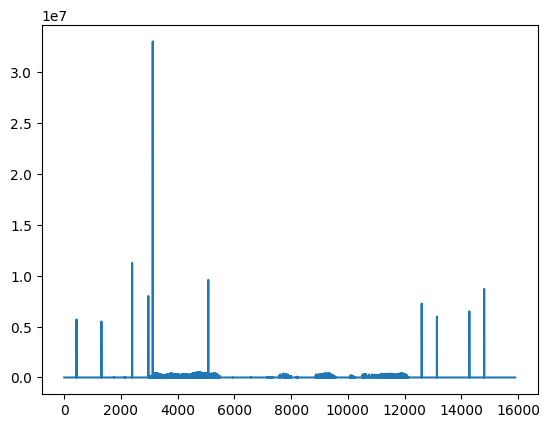

In [230]:
price['anomaly']=price.apply(
    lambda row: row['list_price'] if (row['list_price']>=row['ceiling'] or row['list_price']<=row['floor']) else 0, axis=1
)
price['anomaly'].plot()

In [231]:
price[price['anomaly']!=0]

,property_id,list_price,ceiling,floor,anomaly
433,3.552811e+09,5700000.0,5.272026e+06,-8510.777112,5700000.0
1310,9.409956e+09,5499000.0,5.371257e+06,26041.422888,5499000.0
1748,4.030320e+09,50000.0,5.946234e+06,69036.916221,50000.0
2125,7.299617e+09,25000.0,7.090427e+06,35232.486221,25000.0
2127,3.428073e+09,14900.0,7.096784e+06,33282.486221,14900.0
...,...,...,...,...,...
13142,9.077307e+09,5980000.0,4.676119e+06,-87509.993779,5980000.0
14284,5.066580e+09,6495000.0,6.101662e+06,-99354.973779,6495000.0
14807,6.378957e+09,8695000.0,6.339522e+06,19756.772888,8695000.0
15168,6.403272e+09,8000.0,4.251695e+06,39449.422888,8000.0


In [232]:
price[price['list_price']<=10]

,property_id,list_price,ceiling,floor,anomaly
2184,8.976397e+09,1.0,7.007691e+06,-3457.780446,0.0


In [233]:
result

,lon,lat,fips_code,is_new_construction,is_for_rent,is_contingent,is_price_reduced,is_foreclosure,is_plan,is_coming_soon,...,views,master_bedroom,water_view,vaulted_ceiling,ranch,trails,cul_de_sac,clubhouse,tennis_court,master_suite
property_id,,,,,,,,,,,,,,,,,,,,,
1.000386e+09,-122.278787,37.877566,6001.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1.000797e+09,-122.336493,37.942205,6013.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1.001914e+09,-122.280329,37.877482,6001.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1.001994e+09,-119.161436,35.358035,6029.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1.002195e+09,-121.825823,38.002719,6013.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.980537e+09,-97.070558,32.533213,48139.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
9.983157e+09,-87.298900,36.489861,47125.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
9.986200e+09,-123.082390,44.970707,41053.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [234]:
anomalous_ids = price[price['anomaly']!=0].reset_index()['property_id'].to_list()

In [241]:
price

,property_id,list_price,ceiling,floor,anomaly
0,8.600374e+09,995000.0,NaN,NaN,0.0
1,1.829110e+09,370000.0,NaN,NaN,0.0
2,7.271313e+09,170000.0,NaN,NaN,0.0
3,7.691586e+09,173000.0,NaN,NaN,0.0
4,1.171667e+09,560000.0,NaN,NaN,0.0
...,...,...,...,...,...
15897,2.494361e+09,340000.0,3.748058e+06,-4063.310446,0.0
15898,2.493865e+09,690000.0,3.747853e+06,-2496.643779,0.0
15899,2.581111e+09,630000.0,3.748810e+06,-1596.310446,0.0
15900,2.133101e+09,535000.0,3.744862e+06,-395.977112,0.0


In [235]:
result.drop(anomalous_ids, inplace=True)

In [246]:
anomalous_ids = price[price['anomaly']!=0].reset_index()['property_id'].to_list()
print(price.reset_index().columns)
anomalous_ids += price[price['list_price']<=2000].reset_index()['property_id'].to_list()

Index(['index', 'property_id', 'list_price', 'ceiling', 'floor', 'anomaly'], dtype='object')


In [248]:
len(anomalous_ids)

818

In [245]:
result.index

AttributeError: 'DataFrame' object has no attribute 'index_name'

In [236]:
result.drop(columns='is_for_rent',inplace=True)

In [237]:
result.to_csv('Dataset_modelo_csv.csv')